In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# LIBRARIES

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import numpy as np

from jax import jit, lax, random

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

rng_key = random.PRNGKey(0)

ImportError: cannot import name 'partial' from 'jax.util' (/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/jax/util.py)

# LOAD DATA

In [ ]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')

In [4]:
sampled_true = np.load('sampled_2D_two_clusters_true.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'sampled_2D_two_clusters_true.npy'

In [5]:
data = sampled_perturbed[0 : 1000]

In [174]:
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 10
d = 2

# GIBBS SAMPLER

In [177]:
#FUNCTION TO RUN ONE GIBBS SAMPLER ITERATION
#TAKES IN INPUT VALUES OF THE PREVIOUS ITERATION AND SAMPLE THE NEW VALUES BY THE FUNCTIONS sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
#RETURN:  -cluster_allocs: A VECTOR WITH FOR EVERY DATA POINT THE CLUSTER TO WHICH IT IS ASSIGNED
#         -uniq_vals: A MATRIX WITH #ROWS=CLUSTERS AND 2 COLUMNS, IN EACH COLUMN THERE IS AN ARRAY LIKE [MU[0], VAR[0,0], VAR[0,1]]
#         -weights: A VECTOR WITH THE WEIGHTS OF THE CLUSTERS

@partial(jit, static_argnums=(2,))
def cluster_update(data, cluster_allocs, cluster_idx, uniq_vals, lam, rng_key):
    data_idx = np.where(cluster_allocs == cluster_idx, False, True)
    clusdata = np.delete(data, data_idx,axis=0)
    if len(clusdata) == 0:
        return sample_uniq_vals_prior(lam, rng_key), rng_key
    else:
        return sample_uniq_vals_fullcond(clusdata, lam, rng_key), rng_key
    
#def fai():
    

@jit
def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam, rng_key):

    n_clus = len(weights)
    
    for h in range(n_clus):
        uniq_vals[h, :], rng_key = cluster_update(data, cluster_allocs, h, uniq_vals, lam, rng_key)
    
    weights, rng_key = update_weights(cluster_allocs, n_clus, k, alpha, rng_key)
    
    cluster_allocs, rng_key = update_cluster_allocs(data, weights, uniq_vals, rng_key)
    
    return cluster_allocs, uniq_vals, weights, rng_key


# FUNCTION TO RUN THE ENTIRE MARKOV CHAIN
# TAKES IN INPUT DATA, NUMBER OF CLUSTERS, NUMBER OF ITERATIONS, BURN-IN AND THIN
# IT INITIALIZE THE PARAMETERS AND THEN AT EACH ITERATION CALLS THE FUNCTION run_one_gibbs
# AFTER THE BURN IN IT COLLECT THE PARAMETERS IN THREE LISTS
# RETURN THE LISTS


def run_mcmc(data, k, niter=2500, nburn=500, thin=5, rng_key = rng_key):   
    b = time.time() # only to measure time
    
    rng_key, subk1, subk2, subk3 = random.split(rng_key, 4)
    
    cluster_allocs = np.array(tfd.Categorical(probs=np.ones(k) / k).sample(len(data), seed = subk1))
    weights = np.ones(k) / k
    alpha = 0.1
    lam = 0.1
    
    print(cluster_allocs)
    
    
    
    # 4  bivariate normal e 4 matrices 2x2
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k, seed = subk2),
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k, seed = subk3)])
    
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    for i in range(niter):
        cluster_allocs, uniq_vals, weights, rng_key = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam, rng_key)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out, rng_key

In [42]:
# FUNCTION TO UPDATE THE CLUSTER ALLOCATIONS
# IT EVALUATE THE MIXTURE ON THE DATA AND COMPUTE THE NEW PROBABILITIES FOR EACH CLUSTER AND RETURN THE NEW ALLOCATIONS

@jit
def update_cluster_allocs(data, weights, uniq_vals, rng_key):
    rng_key, subk1, subk2 = random.split(rng_key, 3)
    
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis], seed = subk1)
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/np.sum(np.exp(logprobs), axis=1)[:,None]
    for i in range(len(probs)):
        if np.all(probs[i] == 0):
            probs[i] = np.ones(k) / k
    return tfd.Categorical(probs=probs, validate_args=True).sample(seed = subk2), rng_key


# FUNCTION TO UPDATE THE WEIGHTS 
# IT UPDATES THE PARAMETERS OF THE DIRICHLET AND RETURNS THE NEW WEIGHTS
@jit
def update_weights(cluster_allocs, n_clus, k, alpha, rng_key):
    rng_key, subk1 = random.split(rng_key, 2)

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample(seed = subk1), rng_key


# FUNCTIONS TO SAMPLE FROM THE PRIORS AND FROM THE FULL CONDITIONALS
# THEY BOTH USE THE CHOLESKY FACTORIZATION FOR THE NEW COVARIANCE MATRIX AND THEN SAMPLE FROM A WISHART(COV MATRIX) AND MULTIVARIATE NORMAL(MEAN)
# RETURN AN ARRAY OF ARRAYS
@jit
def sample_uniq_vals_prior(lam, rng_key):
    rng_key, subk1, subk2 = random.split(rng_key, 3)
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample(seed = subk1)
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample(seed = subk2)
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]]), rng_key
    
@jit
def sample_uniq_vals_fullcond(clusdata, lam, rng_key):
    rng_key, subk1, subk2 = random.split(rng_key, 3)
    
    n=len(clusdata)
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0))
    W = tf.linalg.inv(W0 + C + D)
    chol = tf.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=d+n, scale_tril=chol).sample(seed = subk1)
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance((lam * np.mean(np.array(data), axis = 0)+n*np.mean(clusdata, axis = 0))/(lam+n), var/(lam+n)).sample(seed = subk2)
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]]), rng_key


In [178]:
#RUNNING THE MCMC
allocs_out, uniq_vals_out, weights_out, rng_key = run_mcmc(data, k)

[9 6 5 5 2 2 0 7 2 6 6 8 3 0 9 9 1 9 1 0 0 2 9 7 5 9 3 6 8 6 2 7 5 5 7 8 9
 4 0 1 0 5 5 0 7 1 1 7 6 6 9 5 7 8 7 9 8 4 0 7 9 3 5 2 6 1 4 9 3 0 7 2 3 9
 4 0 5 4 4 7 9 3 1 7 8 8 6 2 3 0 4 7 8 1 0 4 1 5 8 3 7 4 5 5 5 9 8 4 8 5 7
 5 7 0 6 1 0 5 5 4 6 5 5 2 0 5 8 9 7 0 6 8 4 9 4 1 6 5 5 3 4 5 5 2 3 9 9 1
 5 7 8 4 3 1 7 6 4 3 8 0 1 2 5 2 8 8 0 8 6 8 2 2 1 6 2 8 4 3 1 9 9 3 4 4 4
 0 9 4 2 5 4 4 6 9 8 8 7 1 5 4 9 7 7 7 9 7 9 6 0 4 6 2 3 7 9 4 3 5 6 1 6 2
 8 2 7 4 8 4 2 9 5 3 8 8 0 6 2 7 6 3 0 5 9 4 4 5 1 3 0 4 1 7 9 5 2 9 7 7 3
 9 1 6 9 4 9 5 5 3 0 7 1 2 2 8 7 2 5 1 3 6 5 6 1 1 0 5 7 2 8 7 3 2 7 8 2 7
 0 2 1 2 2 2 9 7 5 9 3 6 6 6 2 1 4 9 7 7 3 2 6 9 1 8 7 6 2 5 3 5 6 6 1 7 8
 7 8 3 8 0 9 2 4 4 2 6 1 1 3 5 0 9 2 6 0 9 3 0 3 7 6 0 5 8 2 1 5 5 5 8 7 7
 4 9 2 6 1 7 1 0 5 0 4 1 5 2 7 6 4 0 9 4 1 6 3 9 7 3 5 9 8 7 4 3 5 5 3 3 3
 2 6 6 1 3 1 8 5 9 2 4 7 1 4 7 4 2 3 9 1 5 1 7 3 7 3 5 5 1 8 9 9 2 7 0 7 1
 9 6 7 9 3 3 6 4 5 9 0 6 5 3 0 7 8 6 5 9 9 4 0 3 4 5 9 0 0 4 7 8 6 4 9 1 2
 4 1 7 4 0 9 3 8 2 9 7 5 

ValueError: Non-hashable static arguments are not supported. An error occured during a call to 'run_one_gibbs' while trying to hash an object of type <class 'jaxlib.xla_extension.DeviceArray'>, [9 6 5 5 2 2 0 7 2 6 6 8 3 0 9 9 1 9 1 0 0 2 9 7 5 9 3 6 8 6 2 7 5 5 7 8 9
 4 0 1 0 5 5 0 7 1 1 7 6 6 9 5 7 8 7 9 8 4 0 7 9 3 5 2 6 1 4 9 3 0 7 2 3 9
 4 0 5 4 4 7 9 3 1 7 8 8 6 2 3 0 4 7 8 1 0 4 1 5 8 3 7 4 5 5 5 9 8 4 8 5 7
 5 7 0 6 1 0 5 5 4 6 5 5 2 0 5 8 9 7 0 6 8 4 9 4 1 6 5 5 3 4 5 5 2 3 9 9 1
 5 7 8 4 3 1 7 6 4 3 8 0 1 2 5 2 8 8 0 8 6 8 2 2 1 6 2 8 4 3 1 9 9 3 4 4 4
 0 9 4 2 5 4 4 6 9 8 8 7 1 5 4 9 7 7 7 9 7 9 6 0 4 6 2 3 7 9 4 3 5 6 1 6 2
 8 2 7 4 8 4 2 9 5 3 8 8 0 6 2 7 6 3 0 5 9 4 4 5 1 3 0 4 1 7 9 5 2 9 7 7 3
 9 1 6 9 4 9 5 5 3 0 7 1 2 2 8 7 2 5 1 3 6 5 6 1 1 0 5 7 2 8 7 3 2 7 8 2 7
 0 2 1 2 2 2 9 7 5 9 3 6 6 6 2 1 4 9 7 7 3 2 6 9 1 8 7 6 2 5 3 5 6 6 1 7 8
 7 8 3 8 0 9 2 4 4 2 6 1 1 3 5 0 9 2 6 0 9 3 0 3 7 6 0 5 8 2 1 5 5 5 8 7 7
 4 9 2 6 1 7 1 0 5 0 4 1 5 2 7 6 4 0 9 4 1 6 3 9 7 3 5 9 8 7 4 3 5 5 3 3 3
 2 6 6 1 3 1 8 5 9 2 4 7 1 4 7 4 2 3 9 1 5 1 7 3 7 3 5 5 1 8 9 9 2 7 0 7 1
 9 6 7 9 3 3 6 4 5 9 0 6 5 3 0 7 8 6 5 9 9 4 0 3 4 5 9 0 0 4 7 8 6 4 9 1 2
 4 1 7 4 0 9 3 8 2 9 7 5 7 0 9 3 9 1 8 1 8 9 4 2 9 3 1 2 0 2 2 3 4 0 1 5 9
 7 3 1 9 6 8 4 3 9 6 2 9 6 5 9 9 8 8 6 4 7 6 0 5 3 3 5 1 1 8 6 5 8 5 1 6 5
 8 9 4 6 7 6 7 1 6 5 2 0 8 7 3 0 9 3 7 2 7 7 6 2 9 6 3 9 7 2 4 5 8 3 5 2 4
 3 9 5 8 9 9 3 4 6 3 3 6 5 5 4 0 6 0 3 7 8 0 6 1 1 0 9 9 7 7 6 2 9 8 9 7 0
 1 8 4 3 1 4 9 7 9 7 7 4 6 3 4 9 7 7 6 8 0 3 3 7 6 0 4 0 3 0 2 1 8 3 7 2 3
 5 5 7 2 0 5 6 1 3 9 2 9 6 2 4 9 8 7 2 9 2 5 3 0 9 5 0 8 1 2 6 8 7 3 5 7 2
 2 5 3 0 6 6 2 4 9 9 7 4 8 1 0 2 1 0 9 3 2 1 7 9 9 7 2 3 9 2 8 5 0 4 4 9 6
 1 7 8 6 1 3 8 7 4 1 8 6 3 6 8 9 5 0 2 8 1 9 7 3 9 8 1 6 7 3 5 0 2 9 2 0 6
 7 9 1 5 3 2 9 4 7 6 7 3 4 5 7 6 7 5 7 5 5 6 1 0 1 7 5 6 4 4 1 1 9 4 0 2 8
 0 6 9 5 0 4 6 1 1 9 5 9 1 3 0 7 5 1 7 8 2 9 5 3 5 3 7 3 6 5 2 5 8 3 3 5 5
 0 8 8 9 2 4 9 8 2 9 0 0 9 9 5 6 3 4 3 1 0 3 2 4 1 7 1 4 9 6 5 7 4 6 2 4 2
 2 8 9 7 1 0 9 2 7 4 0 1 1 9 0 9 9 6 8 5 0 7 2 2 0 2 3 4 5 9 2 0 6 3 3 0 6
 9 4 5 2 4 4 4 1 8 3 1 1 6 9 0 0 6 3 6 6 7 8 8 9 2 7 6 3 6 2 9 9 9 9 7 2 8
 1 9 3 2 0 9 3 0 6 3 0 6 6 4 0 0 3 4 4 2 8 8 7 8 4 6 1 0 6 4 8 8 4 2 8 2 1
 4]. The error was:
TypeError: unhashable type: 'DeviceArray'


In [40]:
#RUNNING THE MCMC
allocs_out, uniq_vals_out, weights_out, rng_key = run_mcmc(data, k)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
While tracing the function run_one_gibbs at /var/folders/xn/nhr_2py54jv04vmm2_nn63g40000gp/T/ipykernel_59738/2692568381.py:7 for jit, this concrete value was not available in Python because it depends on the value of the argument 'cluster_allocs'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [103]:
data_idx = np.where(allocs_out[-1] == 5, allocs_out[-1], 0)

In [142]:
data_idx = np.where(allocs_out[-1] == 5, False, True)
prova = np.delete(data, data_idx,axis=0)
prova[:10]

array([[4.02026769, 2.14854447],
       [5.52360019, 3.81328414],
       [5.65019359, 6.41726551],
       [3.02762781, 4.51332442],
       [4.92281593, 6.33321223],
       [5.62152057, 4.73149073],
       [2.49110845, 7.98802702],
       [6.26821082, 3.02433235],
       [8.16725149, 5.25089819],
       [5.33437636, 4.90789227]])

In [141]:
data[0:10]

array([[ 4.02026769,  2.14854447],
       [-5.38911704, -7.24109594],
       [ 5.52360019,  3.81328414],
       [ 5.65019359,  6.41726551],
       [-5.04688656, -3.11313566],
       [-2.2723692 , -5.13193909],
       [ 3.02762781,  4.51332442],
       [ 4.92281593,  6.33321223],
       [-7.87748258, -2.5557187 ],
       [ 5.62152057,  4.73149073]])

In [126]:
data_idx

DeviceArray([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
             1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
             1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
             0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
             0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
             1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
             1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
             0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
             0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
             0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
             1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
             0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
             1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,

# PLOT OF THE CLUSTERS

5    496
9    323
8    181
dtype: int64


<BarContainer object of 3 artists>

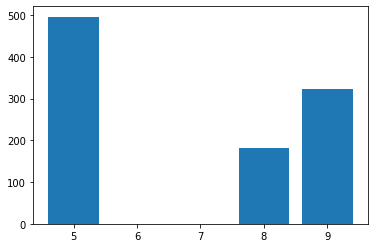

In [10]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)
plt.bar(x, y)

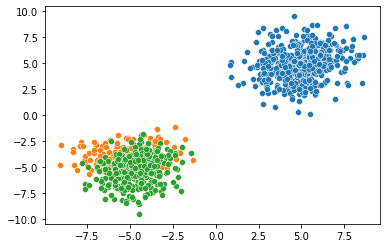

In [11]:
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)

In [36]:
#MEDIE NEI CLUSTER DELL'ULTIMA ITERAZIONE
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in range(k)]

# TRACE PLOTS

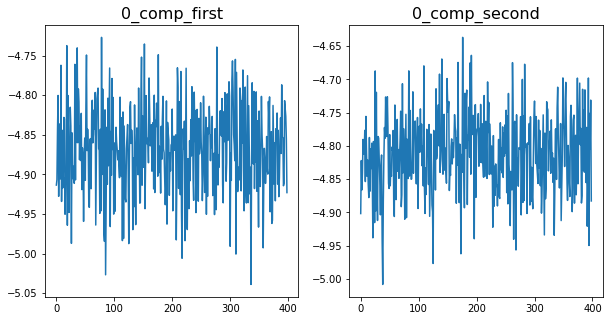

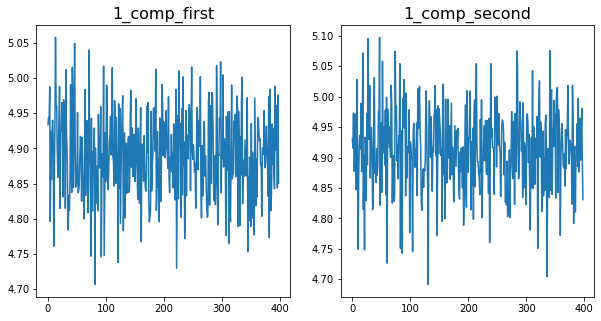

In [37]:
means = [val[:,:,0] for val in uniq_vals_out]
for i in range(len(weights_out[0])):
    

    #Get mean of the first gaussian component
    first_comp = [mean[i,:] for mean in means]

    #Get mu_1 and mu_2 from the first component (multivariate) mean
    first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
    first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
    axes[0].set_title(str(i) + "_comp_first", fontsize=16)

    axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
    axes[1].set_title(str(i) + "_comp_second", fontsize=16)

    plt.show()

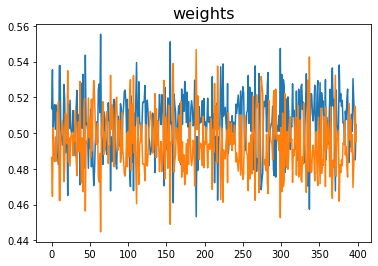

In [38]:
first_weight = [weight[0] for weight in weights_out]
second_weight = [weight[1] for weight in weights_out]
#third_weight = [weight[2] for weight in weights_out]
#fourth_weight = [weight[3] for weight in weights_out]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(len(first_weight)), first_weight)
ax.plot(np.arange(len(second_weight)), second_weight)
#ax.plot(np.arange(len(third_weight)), third_weight)
#ax.plot(np.arange(len(fourth_weight)), fourth_weight)
ax.set_title("weights", fontsize=16)


plt.show()